In [1]:
import numpy as np
import time
import os
import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard
import seaborn as sns

In [2]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

In [3]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [4]:
train_dir = os.path.join("D:/task3/data/emotions_ds/train_class")
validation_dir = os.path.join("D:/task3/data/emotions_ds/val_class")

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=128,
                                                            image_size=IMG_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=32,
                                                                 image_size=IMG_SIZE)

Found 37553 files belonging to 8 classes.
Found 4000 files belonging to 8 classes.


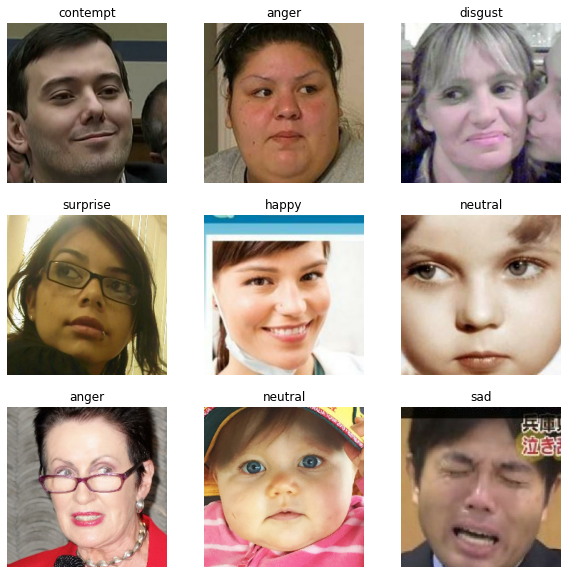

In [5]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
class_names = np.array(train_ds.class_names)
print(class_names)

['anger' 'contempt' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [10]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
predictions = model(image_batch)

In [12]:
predictions.shape

TensorShape([128, 8])

In [13]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [14]:
NUM_EPOCHS = 3

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/3
294/294 [==============================] - 102s 336ms/step - loss: 1.9312 - acc: 0.2641 - val_loss: 1.8494 - val_acc: 0.2982
Epoch 2/3
294/294 [==============================] - 452s 2s/step - loss: 1.7848 - acc: 0.3272 - val_loss: 1.8048 - val_acc: 0.3142
Epoch 3/3
294/294 [==============================] - 343s 1s/step - loss: 1.7347 - acc: 0.3497 - val_loss: 1.7854 - val_acc: 0.3212


In [15]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

4/4 [==============================] - 2s 100ms/step
['anger' 'fear' 'neutral' 'surprise' 'fear' 'anger' 'neutral' 'neutral'
 'anger' 'contempt' 'surprise' 'happy' 'fear' 'anger' 'fear' 'sad' 'fear'
 'happy' 'contempt' 'contempt' 'contempt' 'contempt' 'fear' 'anger'
 'disgust' 'sad' 'surprise' 'fear' 'happy' 'fear' 'happy' 'happy' 'fear'
 'happy' 'sad' 'happy' 'anger' 'happy' 'contempt' 'fear' 'fear' 'fear'
 'contempt' 'sad' 'anger' 'happy' 'surprise' 'surprise' 'fear' 'anger'
 'happy' 'surprise' 'fear' 'anger' 'happy' 'happy' 'fear' 'anger' 'anger'
 'fear' 'disgust' 'surprise' 'happy' 'anger' 'sad' 'happy' 'surprise'
 'happy' 'fear' 'anger' 'anger' 'happy' 'surprise' 'anger' 'disgust'
 'fear' 'surprise' 'neutral' 'happy' 'disgust' 'anger' 'sad' 'fear'
 'contempt' 'happy' 'anger' 'happy' 'neutral' 'anger' 'surprise' 'fear'
 'neutral' 'happy' 'fear' 'anger' 'surprise' 'fear' 'sad' 'sad' 'fear'
 'anger' 'happy' 'contempt' 'neutral' 'happy' 'fear' 'happy' 'fear'
 'neutral' 'surprise' 'sur

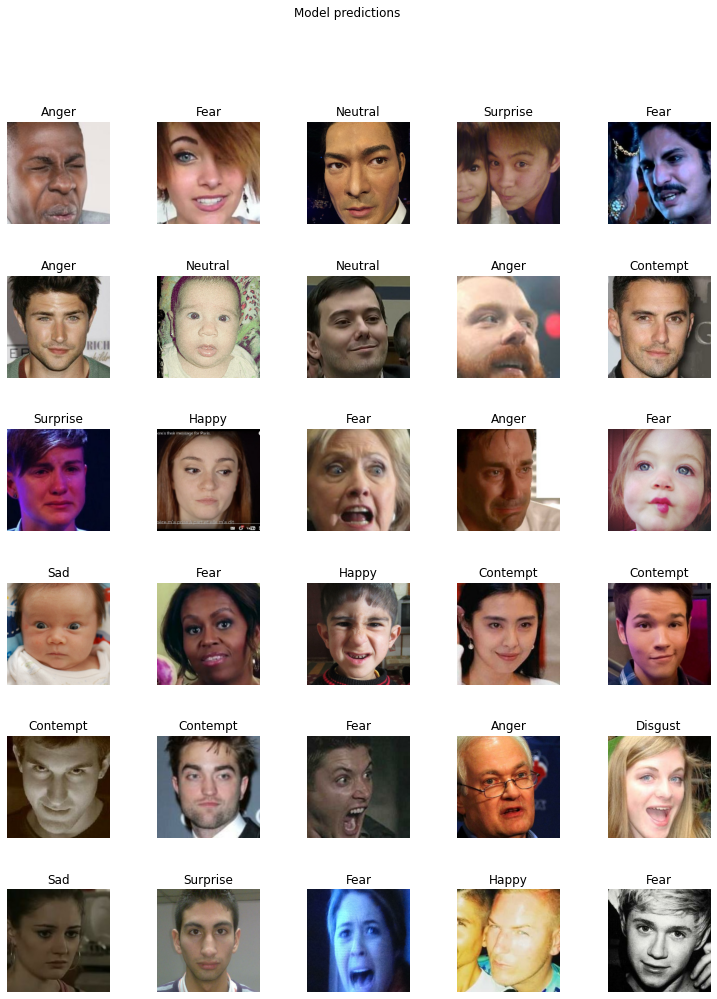

In [19]:
plt.figure(figsize=(13,16))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")